## Dependencies

In [1]:
import torch
from torch import nn

import pytorch_lightning as pl

import torchaudio.transforms as T
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import TIMITDataset, PhonemeLabeler
from utils.utils import set_seed

## Checking CUDA device and setting constant seed value

In [2]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Datasets

In [3]:
dir_name =  r'C:\Data\TIMIT\data'
# dir_name = '/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data' # ubuntu

In [4]:
vowel_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
                'IX', 'AXR', 'AH-H']
consonant_labels = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q', 'JH', 'CH', 'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'M', 'N',
                    'NG', 'EM', 'EN', 'ENG', 'NX']

phoneme_classes = {
    'vowels': vowel_labels,
    'consonants': consonant_labels
}
phone_labels = vowel_labels + consonant_labels

timit_dataset_train = TIMITDataset(usage='train', root_dir=dir_name,
                                   phone_codes=phone_labels, padding=16000, phoneme_labeler=PhonemeLabeler(phoneme_classes, '.'),
                                   description_file_path='../../data/timit_description.csv')

timit_dataset_test = TIMITDataset(usage='test', root_dir=dir_name,
                                  phone_codes=phone_labels, padding=16000, phoneme_labeler=PhonemeLabeler(phoneme_classes, '.'),
                                  description_file_path='../../data/timit_description.csv')

timit_framerate = timit_dataset_train[0].frame_rate

In [5]:
# labels = sorted(list(set(datapoint.label for datapoint in timit_dataset_train)))
# num_of_classes = len(labels)

In [6]:
labels = ['consonants', 'vowels']
num_of_classes = 2

In [7]:
# labels = ['AA',
#           'AE',
#           'AH',
#           'AO',
#           'AW',
#           'AX',
#           'AXR',
#           'AY',
#           'B',
#           'CH',
#           'D',
#           'DX',
#           'EH',
#           'EM',
#           'EN',
#           'ENG',
#           'ER',
#           'EY',
#           'F',
#           'G',
#           'IH',
#           'IX',
#           'IY',
#           'JH',
#           'K',
#           'M',
#           'N',
#           'NG',
#           'NX',
#           'OW',
#           'OY',
#           'P',
#           'Q',
#           'S',
#           'SH',
#           'T',
#           'TH',
#           'UH',
#           'UW',
#           'UX',
#           'V',
#           'Z',
#           'ZH']
# num_of_classes = len(labels)

## Initialization the preprocessing pipeline (torchaudio.transforms)

vowels


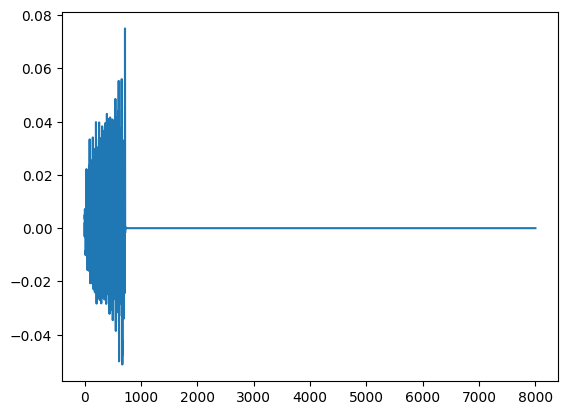

In [8]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)
transform_cpu = T.Resample(orig_freq=timit_framerate, new_freq=8000)

item = 10
timit_waveform = timit_dataset_train[item].data
print(timit_dataset_train[item].label)

transformed = transform(timit_waveform)
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

## Initializing Dataloaders

In [9]:
# def label_to_index(phone):
#     return torch.tensor(labels.index(phone))

def label_to_index(phone):
    if phone == 'consonants':
        return torch.tensor([1, 0])
    else:
        return torch.tensor([0, 1])


def index_to_label(index):
    return labels[index]


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 0
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(transformed.shape[0])

Feature batch shape: torch.Size([256, 1, 16000])
Labels batch shape: torch.Size([256, 2])
1


In [10]:
label_to_index('vowels')

tensor([0, 1])

## Phoneme recognizer

In [11]:
import torch.nn.functional as F

class M3(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=256):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        #
        self.conv2 = self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.fc1 = nn.Linear(n_channel, n_output)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        # return F.log_softmax(x, dim=2)
        return self.sigmoid(x)

In [12]:
# from models.m_models import M3, M11
from models.phoneme_recognizer import PhonemeRecognizer, AudioPreprocessorCallback

model_name = 'M3_cons_vows'

model = PhonemeRecognizer(
    num_classes=num_of_classes,
    acoustic_model=M3,
    model_params=dict(n_input=1, n_output=num_of_classes, stride=4, n_channel=256),
    loss_criterion=nn.BCELoss(),
    lr=3e-1
)

preprocessor_callback = AudioPreprocessorCallback(transform=transform, device=device)

C:\Users\zaits\Documents\VisibleSpeech\PhonemeRecognizer\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'loss_criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_criterion'])`.
  rank_zero_warn(
C:\Users\zaits\Documents\VisibleSpeech\PhonemeRecognizer\venv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (LossMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
          

### Test batch

In [14]:
data, y = next(iter(train_loader))
print(y.shape, y.dtype)
output = model(transform_cpu(data)).squeeze()
print(output.shape, output.dtype)
loss = nn.BCELoss()
loss(output, y.to(torch.float32))

torch.Size([256, 2]) torch.int64
torch.Size([256, 2]) torch.float32


tensor(0.6824, grad_fn=<BinaryCrossEntropyBackward0>)

In [13]:
# loss(torch.Tensor([0.2, 0.3]), torch.Tensor([1, 0]).to(torch.float32))

### Logging

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger('../../logs', name=model_name, log_graph=False, default_hp_metric=False)

In [16]:
%reload_ext tensorboard
%tensorboard --logdir '../../logs'

Launching TensorBoard...

### Training

In [17]:
n_epochs = 50

trainer = pl.Trainer(
    logger=logger,
    accelerator="gpu",
    devices=1,
    callbacks=preprocessor_callback,
    max_epochs=n_epochs,
    log_every_n_steps=10)
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../../logs/M3_cons_vows
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | acoustic_model     | M3               | 219 K 
1 | loss_criterion     | BCELoss          | 0     
2 | train_metrics      | MetricCollection | 0     
3 | val_metrics        | MetricCollection | 0     
4 | test_metrics       | MetricCollection | 0     
5 | checkpoint_metrics | MetricCollection | 0     
--------------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.877     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [35]:


model.forward(timit_waveform.unsqueeze(0).to('cuda'))

tensor([[[4.9404e-04, 9.9951e-01]]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)